In [3]:
import pandas as pd
import numpy as np
from bcb import sgs
from bcb import currency
from datetime import date
from fredapi import Fred
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from scipy.optimize import curve_fit
from sklearn import linear_model

In [4]:
api_key = '5beeb88b7a5cdd7d4fd8b976e138b52e'
fred = Fred(api_key = api_key)

<AxesSubplot:xlabel='Date'>

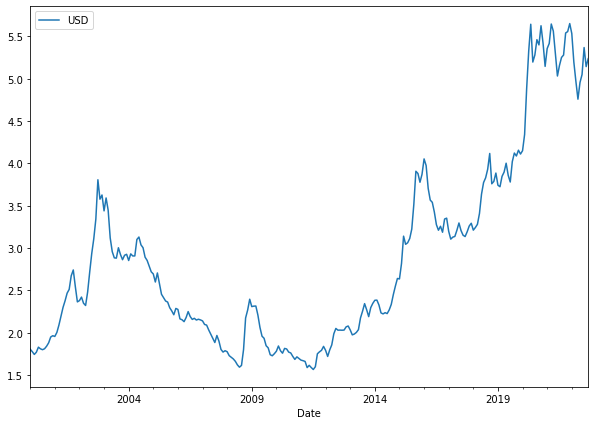

In [5]:
cy = currency.get('USD', start='2000-01-01',end = str(date.today()))
cy = cy.resample('m').mean()
cy = cy.iloc[:-2]
cy.plot(figsize = (10, 7))

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pyGRNN import GRNN
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA

In [27]:
def get_indicators(start_date):
    selic = sgs.get(('SELIC',432),start = start_date)
    ipca = sgs.get(('IPCA',13522),start = start_date)
    emprego = sgs.get(('emprego',28763),start = start_date)
    pib_crescimento = sgs.get(('PIB',1208),start = start_date)
    gdp_eua = fred.get_series(series_id = 'GDPC1',observation_start = start_date)
    cpi = fred.get_series(series_id = 'USACPIALLMINMEI',observation_start = f'{int(start_date[:4]) - 1}{start_date[4:]}')
    inflacion_rate = pd.Series(data = (cpi.values[12:] - cpi.values[:-12]) / cpi.values[:-12],index = cpi.iloc[12:].index)
    employment = fred.get_series(series_id = 'CE16OV',observation_start = start_date)
    interest = fred.get_series(series_id = 'INTDSRUSM193N',observation_start = start_date)
    dataframe = emprego.copy()
    # dataframe = ipca.copy()
    dataframe['emprego'] = dataframe['emprego'] / 100000000
    dataframe['PIB'] = pib_crescimento / 1000000000000
    dataframe['PIB'] = dataframe['PIB'].fillna(method = 'ffill') / 10
    dataframe['SELIC'] = selic['SELIC'] / 100
    dataframe['IPCA'] = ipca['IPCA'] / 100
    dataframe['PIB_EUA'] = gdp_eua
    dataframe['PIB_EUA'] = dataframe['PIB_EUA'].fillna(method = 'ffill') / 100000
    dataframe['CPI'] = inflacion_rate * 10
    dataframe['employment'] = employment / 1000000
    dataframe['interest_rates'] = interest
    dataframe['interest_rates'] = dataframe['interest_rates'].fillna(method = 'ffill') / 10
    return dataframe

def train_test_split(xdata,ydata,horizonte):
    meses = horizonte * 12
    y_train,y_test = ydata.values[:-meses],ydata.values[-meses:]
    x_train,x_test = xdata.values[-meses - len(y_train):-meses],xdata.values[-meses:]
    return x_train,y_train.ravel(),x_test,y_test.ravel()

def no_serial_split(xdata,ydata,horizonte):
    y_conv = [0] + [ydata.values[i + 1] - ydata.values[i] for i in range(len(ydata) - 1)]
    meses = horizonte * 12
    y_train,y_test = y_conv[:-meses],ydata[-meses:]
    x_begin = (-2 * meses) - len(y_train)
    xdata = xdata.iloc[x_begin:-meses].copy()
    xdata['month'] = ydata.index.month
    xdata['quarter'] = ydata.index.quarter
    x_train,x_test = xdata.values[:-meses],xdata.values[-meses:]
    return np.array(x_train),np.array(y_train).ravel(),np.array(x_test),np.array(y_test).ravel()

def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

def exp(x,a,b,c):
    return (np.exp(a * x) * b) + c

def linear(x,a,b,c):
    return (x * a) + b + c

class base_model:
    def __init__(self,data,func):
        self.data = data
        self.func = func
    def fit(self):
        y = self.data
        self.popt = curve_fit(self.func,list(range(len(y))),y)[0]
        self.x0 = len(y)
        self.last_y = y[-1]
        return self
    def predict(self,n):
        prediction = np.array([self.func(x,self.popt[0],self.popt[1],self.popt[2]) for x in range(self.x0,self.x0 + n)])
        diferenca = prediction[0] - self.last_y
        return prediction - diferenca

class modelo:
    def __init__(self,name,ydata,xdata = None):
        self.name = name
        if name == 'holt':
            self.model = ExponentialSmoothing(ydata,seasonal_periods = 12,trend = "add",seasonal = "add").fit(0,0,0)
        if name == 'arima':
            self.model = AutoARIMA(sp = 12,suppress_warnings = True).fit(ydata)

    def predict(self,n = None,data = None):
        if self.name == 'holt':
            return self.model.forecast(n)
        if self.name == 'arima':
            return self.model.predict(fh = list(range(1,n + 1))).ravel()

class GodModel:
    def __init__(self,func,modelo,peso = 0.5):
        self.peso = peso
        self.func = func
        self.name = modelo
    
    def fit(self,target_data,extra_data):
        # Regressão linear das features secundarias
        self.reg = linear_model.LinearRegression()
        self.reg.fit(extra_data,target_data)
        # Regressão polinomial no tempo
        self.x0 = len(target_data)
        self.features = range(len(extra_data[0]))
        self.popts = [curve_fit(self.func,list(range(self.x0)),extra_data[:,i])[0] for i in self.features]
        self.popts_main = curve_fit(self.func,list(range(self.x0)),target_data)[0]
        self.last_y = [extra_data[:,i][-1] for i in self.features]
        self.last_y_main = target_data[-1]
        # Sazonalidade
        data = pd.DataFrame({'y':target_data})
        data['mavg'] = data['y'].rolling(12,center = True).mean()
        data['mavg'] = data['mavg'].fillna(method = 'ffill')
        data['mavg'] = data['mavg'].fillna(method = 'bfill')
        data['no_trend'] = data['y'] - data['mavg']
        self.model = modelo(self.name,data['no_trend'].values)
        self.target_data = target_data
        self.extra_data = extra_data
        return self

    def predict(self,n):
        predictions = []
        for i in self.features:
            popt = self.popts[i]
            last_y = self.last_y[i]
            prediction = np.array([self.func(x,popt[0],popt[1],popt[2]) for x in range(self.x0,self.x0 + n)])
            diferenca = prediction[0] - last_y
            prediction = prediction - diferenca
            predictions.append(prediction)
        main_prediction = np.array([self.func(x,self.popts_main[0],self.popts_main[1],self.popts_main[2]) for x in range(self.x0,self.x0 + n)])
        predictores = np.array(predictions).T
        feat_prediction = self.reg.predict(predictores)
        trend = (main_prediction * self.peso) + (feat_prediction * (1 - self.peso))
        seasonality = self.model.predict(n)
        prediction_final = trend + seasonality
        prediction_final[0] = self.target_data[-1]
        return prediction_final


In [8]:
df = get_indicators('2000-01-01')

MSE: 0.04776199094815051
RMSE: 0.21854516912563066


<AxesSubplot:xlabel='Date'>

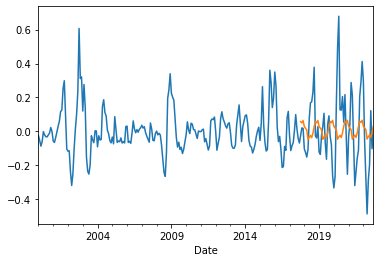

In [18]:
anos = 5
data = cy.copy()
data['mavg'] = data['USD'].rolling(12,center = True).mean()
data['mavg'] = data['mavg'].fillna(method = 'ffill')
data['mavg'] = data['mavg'].fillna(method = 'bfill')
data['no_trend'] = data['USD'] - data['mavg']
train,test = data.iloc[:-anos * 12]['no_trend'].values,data.iloc[-anos * 12:]['no_trend'].values
model = ExponentialSmoothing(train,seasonal_periods = 12,trend = "add",seasonal = "add").fit(0,0,0)
prediction = model.forecast(anos * 12)
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
print('MSE:',mean_squared_error(prediction,test))
print('RMSE:',rmse(prediction,test))
data['no_trend'].plot()
data['pred'].plot()

Executing warm start...
Warm start concluded. The optimum isotropic sigma is [1.64502503]
Gradient search concluded. The optimum sigma is [1.64501242 1.6449885 ]
MSE: 0.04678261942243162
RMSE: 0.21629290192336784


<AxesSubplot:xlabel='Date'>

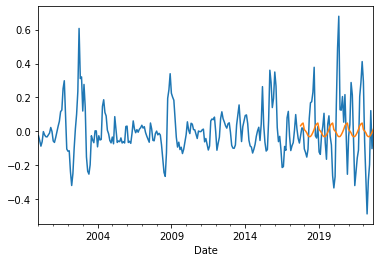

In [10]:
anos = 5
data = cy.copy()
data['mes'] = data.index.month
data['quarter'] = data.index.quarter
data['mavg'] = data['USD'].rolling(12,center = True).mean()
data['mavg'] = data['mavg'].fillna(method = 'ffill')
data['mavg'] = data['mavg'].fillna(method = 'bfill')
data['no_trend'] = data['USD'] - data['mavg']
x_train,y_train,x_test = data[['mes','quarter']].iloc[:-anos * 12].values,data['no_trend'].iloc[:-anos * 12].values,data[['mes','quarter']].iloc[-anos * 12:].values
y_test = data['no_trend'].iloc[-anos * 12:].values
model = GRNN().fit(x_train,y_train)
prediction = model.predict(x_test)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.04634171109343065
RMSE: 0.21527125003917882


<AxesSubplot:xlabel='Date'>

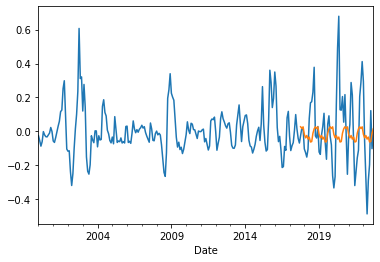

In [11]:
anos = 5
data = cy.copy()
data['mavg'] = data['USD'].rolling(12,center = True).mean()
data['mavg'] = data['mavg'].fillna(method = 'ffill')
data['mavg'] = data['mavg'].fillna(method = 'bfill')
data['no_trend'] = data['USD'] - data['mavg']
train,test = data.iloc[:-anos * 12]['no_trend'].values,data.iloc[-anos * 12:]['no_trend'].values
forecaster = TBATS(use_box_cox=False,use_trend=False,use_damped_trend=False,sp=12,use_arma_errors=False)
forecaster.fit(data['no_trend'].values)
prediction = forecaster.predict(fh = [i for i in range(1,(anos * 12) + 1)]).ravel()
print('MSE:',mean_squared_error(prediction,test))
print('RMSE:',rmse(prediction,test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.045411753628259416
RMSE: 0.21310033699705735


<AxesSubplot:xlabel='Date'>

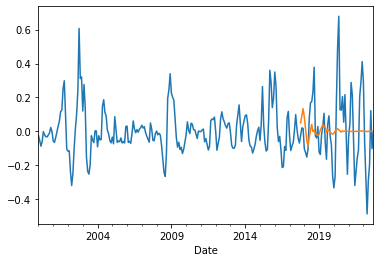

In [12]:
anos = 5
data = cy.copy()
data['mavg'] = data['USD'].rolling(12,center = True).mean()
data['mavg'] = data['mavg'].fillna(method = 'ffill')
data['mavg'] = data['mavg'].fillna(method = 'bfill')
data['no_trend'] = data['USD'] - data['mavg']
train,test = data.iloc[:-anos * 12]['no_trend'].values,data.iloc[-anos * 12:]['no_trend'].values
forecaster = AutoARIMA(sp = 12,suppress_warnings = True)
forecaster.fit(data['no_trend'].values)
prediction = forecaster.predict(fh = [i for i in range(1,(anos * 12) + 1)]).ravel()
print('MSE:',mean_squared_error(prediction,test))
print('RMSE:',rmse(prediction,test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.04641124738854818
RMSE: 0.21543269804871354


C:\Users\aruav\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sktime\forecasting\naive.py:169: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn("For the `drift` strategy, the `sp` value will be ignored.")


<AxesSubplot:xlabel='Date'>

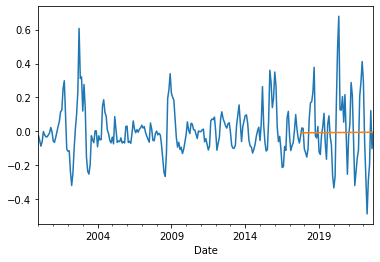

In [13]:
anos = 5
data = cy.copy()
data['mavg'] = data['USD'].rolling(12,center = True).mean()
data['mavg'] = data['mavg'].fillna(method = 'ffill')
data['mavg'] = data['mavg'].fillna(method = 'bfill')
data['no_trend'] = data['USD'] - data['mavg']
train,test = data.iloc[:-anos * 12]['no_trend'].values,data.iloc[-anos * 12:]['no_trend'].values
forecaster = NaiveForecaster(sp = 12,strategy = 'drift')
forecaster.fit(data['no_trend'].values)
prediction = forecaster.predict(fh = [i for i in range(1,(anos * 12) + 1)]).ravel()
print('MSE:',mean_squared_error(prediction,test))
print('RMSE:',rmse(prediction,test))
data['pred'] = [None for _ in range(len(data) - (anos * 12))] + list(prediction)
data['no_trend'].plot()
data['pred'].plot()

MSE: 0.6683974605682519
RMSE: 0.8175557843769756


<AxesSubplot:xlabel='Date'>

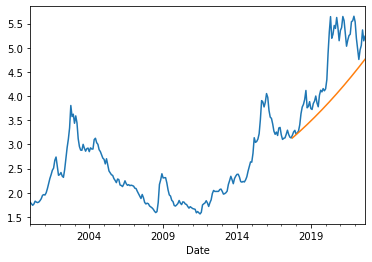

In [7]:
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,cy,anos)
model = base_model(y_train,square).fit()
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = cy.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['USD'].plot()
pred_df['prediction'].plot()

MSE: 0.6770463538855797
RMSE: 0.8228282651231541


<AxesSubplot:xlabel='Date'>

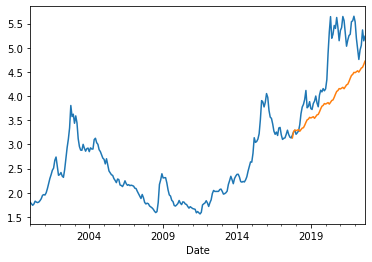

In [29]:
anos = 5
x_train,y_train,x_test,y_test = train_test_split(df,cy,anos)
model = GodModel(square,'holt',0.5).fit(y_train,x_train)
prediction = model.predict(12 * anos)
print('MSE:',mean_squared_error(prediction,y_test))
print('RMSE:',rmse(prediction,y_test))
pred_df = cy.copy()
pred_df['prediction'] = [None for _ in range(len(pred_df) - len(prediction))] + list(prediction.ravel())
pred_df['USD'].plot()
pred_df['prediction'].plot()

<AxesSubplot:>

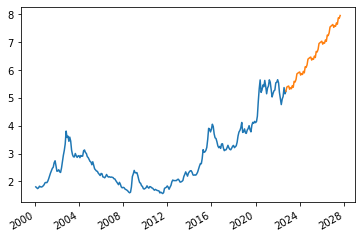

In [121]:
x_train,y_train = df.values,cy.values.ravel()
model = GodModel(square,'holt',0.5).fit(y_train,x_train)
prediction = model.predict(12 * 5)
pred_df = cy.copy()
pred_df['prediction'] = None
new_df = pd.DataFrame({'prediction':prediction,'USD':None},index = pd.date_range(start = pred_df.index[-1],freq = 'M',periods = 12 * 5))
pred_df = pd.concat([pred_df,new_df])
pred_df['USD'].plot()
pred_df['prediction'].plot()